# Assignment 9: Self-Supervised Learning - Kai Ponel & Hannan Mahadik



# Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
tfkl = tf.keras.layers

# Dataset

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
X_train = train_images.astype('float32') / 255.0
X_test = test_images.astype('float32') / 255.0

y_train= train_labels.astype(np.int32).reshape((-1,))
y_test = test_labels.astype(np.int32).reshape((-1,))

In [4]:
batch_size = 256

In [5]:
def gaussian_noise(batch, std):
  shape = batch.shape[1:]
  noise = np.random.normal(scale=std, size=shape)
  return batch + noise

dae_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, X_train))
  #.shuffle(1024)
  .batch(batch_size)
  .map(lambda X, y: (gaussian_noise(X, 0.1), y)))

dae_test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, X_test))
  .shuffle(1024)
  .batch(batch_size))

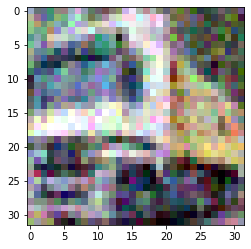

In [6]:
for X_noise_batch, X_batch in dae_train_dataset:
  image = tf.cast(X_noise_batch[1] * 255, tf.int32)
  plt.imshow(image, cmap = "Greys_r")

  break

In [7]:
cl_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
  .shuffle(1024)
  .batch(batch_size))

cl_test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
  .shuffle(1024)
  .batch(batch_size))

# Classification Head

In [8]:
class ClassificationHead(tf.keras.models.Model):
  def __init__(self, num_hidden_units, num_output_units):
    super(ClassificationHead, self).__init__()

    self.num_hidden_units = num_hidden_units
    self.num_output_units = num_output_units

  def build(self, input_shape):
    
    self.hidden_layer = tf.keras.layers.Dense(self.num_hidden_units, activation='ReLU',
                                         input_shape = input_shape)
    self.output_layer = tf.keras.layers.Dense(self.num_output_units, 
                                         input_shape = (input_shape[0], 
                                                        num_hidden_units))
    
  def call(self, input):
    h = self.hidden_layer(input)
    y_pred = self.output_layer(h)
    
    return y_pred

In [9]:
encoding_dim = 64
num_hidden_units = 128
num_output_units = 10

# MLP Encoder

In [10]:
# Encoder
image_input = tf.keras.Input((32, 32, 3))
flattened = tf.keras.layers.Flatten()(image_input)
encoding1 = tf.keras.layers.Dense(256, activation='relu')(flattened)
encoding2 = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoding1)
mlp_encoder = tf.keras.Model(image_input, encoding2)

# Decoder
code_input = tf.keras.Input((encoding_dim,))
decoding1 = tf.keras.layers.Dense(256, activation='relu')(code_input)
decoding2 = tf.keras.layers.Dense(32 * 32 * 3, activation='sigmoid')(decoding1)
reshaped = tf.keras.layers.Reshape((-1, 32, 32, 3))(decoding2)
mlp_decoder = tf.keras.Model(code_input, reshaped)

# Autoencoder
mlp_autoencoder = tf.keras.Model(image_input, mlp_decoder(mlp_encoder(image_input)))

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

mlp_autoencoder.compile(optimizer = optimizer, loss = loss_fn)

In [12]:
mlp_autoencoder.fit(dae_train_dataset, epochs = 5, 1
                    validation_data = dae_test_dataset)

Epoch 1/5
196/196 [==============================] - 32s 152ms/step - loss: 0.6895 - val_loss: 0.6903
Epoch 2/5
196/196 [==============================] - 30s 152ms/step - loss: 0.6892 - val_loss: 0.6897
Epoch 3/5
196/196 [==============================] - 30s 153ms/step - loss: 0.6892 - val_loss: 0.6896
Epoch 4/5
196/196 [==============================] - 30s 153ms/step - loss: 0.6892 - val_loss: 0.6895
Epoch 5/5
196/196 [==============================] - 30s 153ms/step - loss: 0.6891 - val_loss: 0.6894


# CNN Encoder

In [13]:
# Encoder
image_input = tf.keras.Input((32, 32, 3))                                                    # 32x32x3
conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation = 'relu')(image_input)      # 32x32x32
pool1 = tf.keras.layers.MaxPool2D()(conv1)                                                   # 16x16x32
conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation = 'relu')(pool1)            # 16x16x64
pool2 = tf.keras.layers.MaxPool2D()(conv2)                                                   # 8x8x64
conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation = 'relu')(pool2)           # 8x8x128
pool3 = tf.keras.layers.MaxPool2D()(conv3)                                                   # 4x4x128
flattened = tf.keras.layers.Flatten()(pool3)
encoding = tf.keras.layers.Dense(encoding_dim, activation = 'relu')(flattened)
cnn_encoder = tf.keras.Model(image_input, encoding)

# Decoder
code_input = tf.keras.Input((encoding_dim,))
dense = tf.keras.layers.Dense(4 * 4 * 128, activation = 'relu')(code_input)
reshaped = tf.keras.layers.Reshape((4, 4, 128))(dense)                                       # 4x4x128
deconv1 = tf.keras.layers.Conv2DTranspose(64, 5, activation='relu')(reshaped)                # 8x8x64
deconv2 = tf.keras.layers.Conv2DTranspose(32, 9, activation='relu')(deconv1)                 # 16x16x32
deconv3 = tf.keras.layers.Conv2DTranspose(3, 17, activation='sigmoid')(deconv2)              # 32x32x3
cnn_decoder = tf.keras.Model(code_input, deconv3)

# Autoencoder
cnn_autoencoder = tf.keras.Model(image_input, cnn_decoder(cnn_encoder(image_input)))

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

cnn_autoencoder.compile(optimizer = optimizer, loss = loss_fn)

In [15]:
cnn_autoencoder.fit(dae_train_dataset, epochs = 5, 
                    validation_data = dae_test_dataset)

Epoch 1/5
196/196 [==============================] - 12s 26ms/step - loss: 0.6465 - val_loss: 0.6377
Epoch 2/5
196/196 [==============================] - 5s 24ms/step - loss: 0.6094 - val_loss: 0.6339
Epoch 3/5
196/196 [==============================] - 5s 24ms/step - loss: 0.5993 - val_loss: 0.6101
Epoch 4/5
196/196 [==============================] - 5s 24ms/step - loss: 0.5916 - val_loss: 0.6191
Epoch 5/5
196/196 [==============================] - 5s 24ms/step - loss: 0.5888 - val_loss: 0.6322


# Denoising CNN Autoencoder

In [18]:
# Encoder
image_input = tf.keras.Input((32, 32, 3))                                                    # 32x32x3
conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation = 'relu')(image_input)      # 32x32x32
pool1 = tf.keras.layers.MaxPool2D()(conv1)                                                   # 16x16x32
conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation = 'relu')(pool1)            # 16x16x64
pool2 = tf.keras.layers.MaxPool2D()(conv2)                                                   # 8x8x64
conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation = 'relu')(pool2)           # 8x8x128
pool3 = tf.keras.layers.MaxPool2D()(conv3)                                                   # 4x4x128
flattened = tf.keras.layers.Flatten()(pool3)
encoding = tf.keras.layers.Dense(encoding_dim, activation = 'relu')(flattened)
denoising_cnn_encoder = tf.keras.Model(image_input, encoding)

# Decoder
code_input = tf.keras.Input((encoding_dim,))
dense = tf.keras.layers.Dense(4 * 4 * 128, activation = 'relu')(code_input)
reshaped = tf.keras.layers.Reshape((4, 4, 128))(dense)                                       # 4x4x128
deconv1 = tf.keras.layers.Conv2DTranspose(64, 5, activation='relu')(reshaped)                # 8x8x64
deconv2 = tf.keras.layers.Conv2DTranspose(32, 9, activation='relu')(deconv1)                 # 16x16x32
deconv3 = tf.keras.layers.Conv2DTranspose(3, 17, activation='sigmoid')(deconv2)              # 32x32x3
denoising_cnn_decoder = tf.keras.Model(code_input, deconv3)

# Autoencoder
denoising_cnn_autoencoder = tf.keras.Model(
    image_input, denoising_cnn_decoder(denoising_cnn_encoder(image_input)))

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

denoising_cnn_autoencoder.compile(optimizer = optimizer, loss = loss_fn)

In [20]:
denoising_cnn_autoencoder.fit(dae_train_dataset, epochs = 5,
                              validation_data = dae_test_dataset)

Epoch 1/5
196/196 [==============================] - 6s 25ms/step - loss: 0.6449 - val_loss: 0.6530
Epoch 2/5
196/196 [==============================] - 5s 24ms/step - loss: 0.6081 - val_loss: 0.6173
Epoch 3/5
196/196 [==============================] - 5s 24ms/step - loss: 0.5984 - val_loss: 0.6270
Epoch 4/5
196/196 [==============================] - 5s 24ms/step - loss: 0.5934 - val_loss: 0.6135
Epoch 5/5
196/196 [==============================] - 5s 24ms/step - loss: 0.5905 - val_loss: 0.6342


# MLP Classification

In [21]:
image_input = tf.keras.Input((32, 32, 3))
flatten = tf.keras.layers.Flatten()(image_input)
layer1 = tf.keras.layers.Dense(256, activation='relu')(flatten)
layer2 = tf.keras.layers.Dense(encoding_dim, activation='relu')(layer1)
layer3 = tf.keras.layers.Dense(256, activation='relu')(layer2)
output = tf.keras.layers.Dense(10)(layer3)

simp_mlp_class_model = tf.keras.Model(image_input, output)

loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
simp_mlp_class_model.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)

In [22]:
simp_mlp_class_model.fit(cl_train_dataset, epochs = 5, validation_data = cl_test_dataset)

Epoch 1/5
196/196 [==============================] - 2s 6ms/step - loss: 1.9040 - categorical_accuracy: 0.1123 - val_loss: 1.7261 - val_categorical_accuracy: 0.1136
Epoch 2/5
196/196 [==============================] - 1s 7ms/step - loss: 1.6938 - categorical_accuracy: 0.1026 - val_loss: 1.6230 - val_categorical_accuracy: 0.1236
Epoch 3/5
196/196 [==============================] - 1s 7ms/step - loss: 1.6133 - categorical_accuracy: 0.1004 - val_loss: 1.5851 - val_categorical_accuracy: 0.1161
Epoch 4/5
196/196 [==============================] - 1s 7ms/step - loss: 1.5486 - categorical_accuracy: 0.0999 - val_loss: 1.5374 - val_categorical_accuracy: 0.1041
Epoch 5/5
196/196 [==============================] - 1s 7ms/step - loss: 1.5088 - categorical_accuracy: 0.0994 - val_loss: 1.5038 - val_categorical_accuracy: 0.0923


# Autoencoder with classification (non trainable encoder):


## MLP 

In [24]:
image_input = tf.keras.Input((32, 32, 3))
mlp_encoder.trainable = False
classifier1 = ClassificationHead(256, 10)
mlp_classifier = tf.keras.Model(image_input, classifier1(mlp_encoder(image_input)))

loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
mlp_classifier.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)

In [25]:
mlp_classifier.fit(cl_train_dataset, epochs = 5, validation_data = cl_test_dataset)

Epoch 1/5
196/196 [==============================] - 2s 7ms/step - loss: 2.2766 - categorical_accuracy: 0.3554 - val_loss: 2.2420 - val_categorical_accuracy: 0.4468
Epoch 2/5
196/196 [==============================] - 1s 6ms/step - loss: 2.2150 - categorical_accuracy: 0.2855 - val_loss: 2.1988 - val_categorical_accuracy: 0.3301
Epoch 3/5
196/196 [==============================] - 1s 7ms/step - loss: 2.1936 - categorical_accuracy: 0.2340 - val_loss: 2.1921 - val_categorical_accuracy: 0.2791
Epoch 4/5
196/196 [==============================] - 1s 7ms/step - loss: 2.1895 - categorical_accuracy: 0.2214 - val_loss: 2.1911 - val_categorical_accuracy: 0.2843
Epoch 5/5
196/196 [==============================] - 1s 7ms/step - loss: 2.1876 - categorical_accuracy: 0.2129 - val_loss: 2.1883 - val_categorical_accuracy: 0.2330


## CNN Autoencoder

In [26]:
image_input = tf.keras.Input((32, 32, 3))
cnn_encoder.trainable = False
classifier2 = ClassificationHead(256, 10)
cnn_classifier = tf.keras.Model(image_input, classifier2(cnn_encoder(image_input)))

loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
cnn_classifier.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)

In [27]:
cnn_classifier.fit(cl_train_dataset, epochs = 5, validation_data = cl_test_dataset)

Epoch 1/5
196/196 [==============================] - 2s 10ms/step - loss: 1.9421 - categorical_accuracy: 0.1083 - val_loss: 1.8066 - val_categorical_accuracy: 0.0667
Epoch 2/5
196/196 [==============================] - 2s 9ms/step - loss: 1.7710 - categorical_accuracy: 0.0902 - val_loss: 1.7318 - val_categorical_accuracy: 0.0739
Epoch 3/5
196/196 [==============================] - 2s 9ms/step - loss: 1.7123 - categorical_accuracy: 0.0891 - val_loss: 1.6896 - val_categorical_accuracy: 0.0745
Epoch 4/5
196/196 [==============================] - 2s 9ms/step - loss: 1.6733 - categorical_accuracy: 0.0883 - val_loss: 1.6659 - val_categorical_accuracy: 0.0631
Epoch 5/5
196/196 [==============================] - 2s 9ms/step - loss: 1.6442 - categorical_accuracy: 0.0887 - val_loss: 1.6250 - val_categorical_accuracy: 0.0723


## CNN denoise Autoencoder

In [28]:
image_input = tf.keras.Input((32, 32, 3))
denoising_cnn_encoder.trainable = False
classifier3 = ClassificationHead(256, 10)
cnn_den_classifier = tf.keras.Model(image_input, classifier3(denoising_cnn_encoder(image_input)))

loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
cnn_den_classifier.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)

In [29]:
cnn_den_classifier.fit(cl_train_dataset, epochs = 5, validation_data = cl_test_dataset)

Epoch 1/5
196/196 [==============================] - 2s 10ms/step - loss: 1.9175 - categorical_accuracy: 0.1008 - val_loss: 1.8052 - val_categorical_accuracy: 0.0937
Epoch 2/5
196/196 [==============================] - 2s 9ms/step - loss: 1.7782 - categorical_accuracy: 0.0929 - val_loss: 1.7395 - val_categorical_accuracy: 0.0822
Epoch 3/5
196/196 [==============================] - 2s 9ms/step - loss: 1.7206 - categorical_accuracy: 0.0916 - val_loss: 1.6914 - val_categorical_accuracy: 0.1016
Epoch 4/5
196/196 [==============================] - 2s 9ms/step - loss: 1.6781 - categorical_accuracy: 0.0925 - val_loss: 1.6659 - val_categorical_accuracy: 0.0959
Epoch 5/5
196/196 [==============================] - 2s 9ms/step - loss: 1.6459 - categorical_accuracy: 0.0894 - val_loss: 1.6514 - val_categorical_accuracy: 0.1003
